In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
import os
import time

import warnings
warnings.filterwarnings('ignore', module='statsmodels.tsa.arima_model.ARIMA',category=FutureWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

%matplotlib inline

In [8]:
# import the raw data of weekly Apple stock prices from 2015 to 2019
dt_weekly = pd.read_csv('../RawData/AAPL_2015_2019_weekly.csv')

# ***1. Data Wangling***

In [9]:
# check the info
dt_weekly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       261 non-null    object 
 1   Open       261 non-null    float64
 2   High       261 non-null    float64
 3   Low        261 non-null    float64
 4   Close      261 non-null    float64
 5   Adj Close  261 non-null    float64
 6   Volume     261 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 14.4+ KB


In [10]:
# check the first 5 rows
dt_weekly.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-01,27.847500,27.860001,26.157499,26.937500,24.460564,893572400
1,2015-01-08,27.307501,28.312500,27.125000,27.450001,24.925943,1115053200
2,2015-01-15,27.500000,27.764999,26.299999,27.387501,24.869184,948012400
3,2015-01-22,27.565001,29.530001,27.257500,28.827499,26.176777,1591688000
4,2015-01-29,29.080000,30.127501,28.889999,29.889999,27.141579,1411945600


In [11]:
# check the last 5 rows
dt_weekly.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
256,2019-11-28,66.650002,67.062500,64.072502,65.434998,64.668098,322716800
257,2019-12-05,65.947502,67.775002,65.682503,67.692497,66.899139,477719600
258,2019-12-12,66.945000,70.474998,66.830002,69.934998,69.115349,629270800
259,2019-12-19,69.875000,71.222504,69.639999,71.067497,70.234581,521398000
260,2019-12-26,71.205002,73.492500,71.175003,72.879997,72.025833,383501600


In [12]:
dt_weekly.describe()

,Open,High,Low,Close,Adj Close,Volume
count,261.000000,261.000000,261.000000,261.000000,261.000000,2.610000e+02
mean,38.564626,39.485833,37.679856,38.731571,37.023835,6.917529e+08
std,10.979085,11.304472,10.787337,11.130494,11.479266,2.833257e+08
min,23.180000,23.517500,22.367500,23.127501,21.474611,2.657236e+08
25%,28.980000,29.412500,28.110001,28.897499,26.756763,4.893424e+08
50%,37.875000,38.720001,36.647499,38.314999,36.359734,6.315080e+08
75%,46.025002,47.317501,45.182499,46.040001,44.853859,8.388528e+08
max,71.205002,73.492500,71.175003,72.879997,72.025833,2.237438e+09


# ***2. EDA***

<AxesSubplot:>

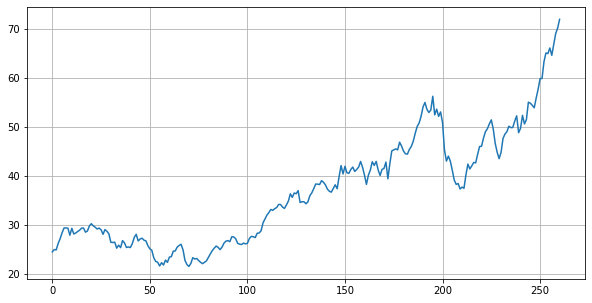

In [13]:
# plot the data to check the basic trend of Adj Close price for 5 years
dt_weekly['Adj Close'].plot(figsize =(10,5), grid=True)

<AxesSubplot:>

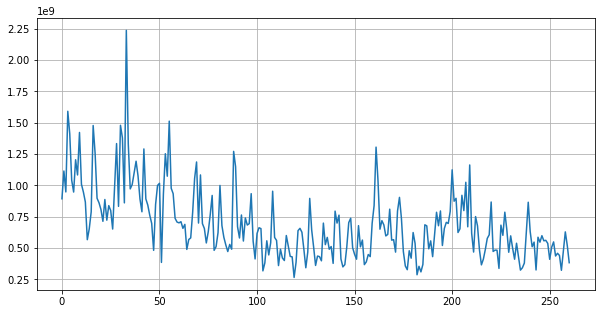

In [14]:
# plot the data to check the trend for trading volume for 5 years
dt_weekly['Volume'].plot(figsize =(10,5), grid=True)

<AxesSubplot:>

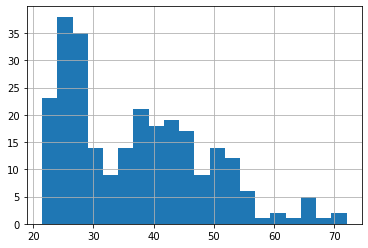

In [15]:
# hist for Adj Close price for 5 years
dt_weekly['Adj Close'].hist(bins=20)

<AxesSubplot:>

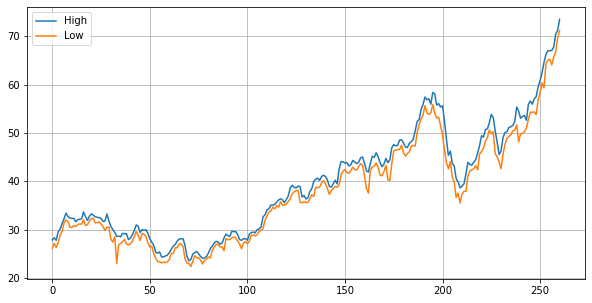

In [16]:
# plot for high and low price for 5 years
dt_weekly[['High','Low']].plot(figsize =(10,5), grid=True)

<AxesSubplot:ylabel='Density'>

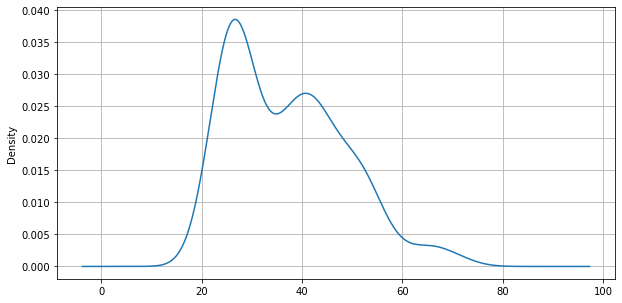

In [17]:
# Kernal Density plot for Adj Close price for 5 years
dt_weekly['Adj Close'].plot(kind='kde',figsize =(10,5), grid=True)

<AxesSubplot:ylabel='Density'>

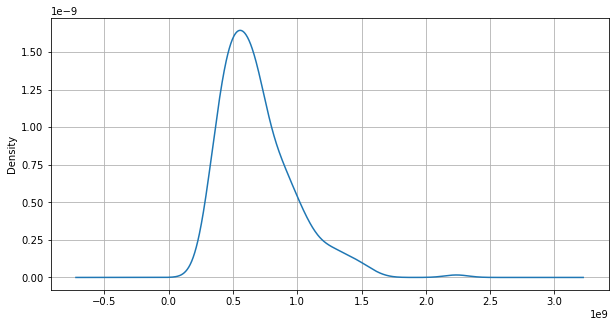

In [18]:
# Kernal Density plot for Volume for 5 years
dt_weekly['Volume'].plot(kind='kde',figsize =(10,5), grid=True)

<AxesSubplot:>

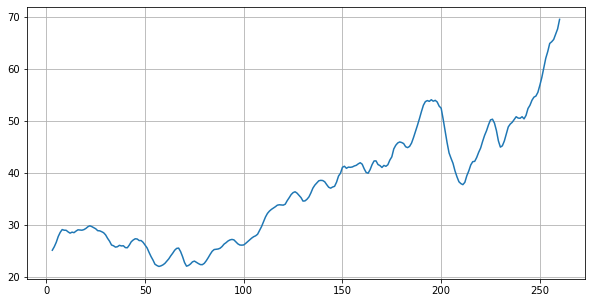

In [19]:
# plot moving average (rolling mean) for Adj Close price
dt_weekly['Adj Close'].rolling(4).mean().plot(figsize =(10,5), grid=True)

<AxesSubplot:>

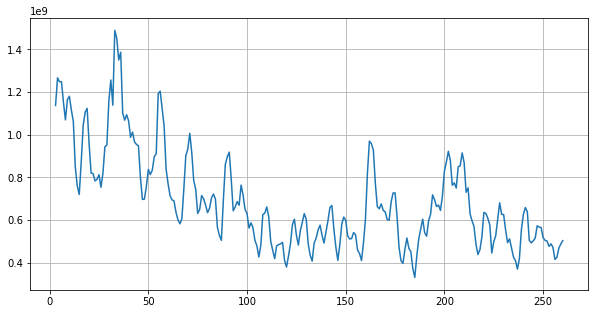

In [20]:
# plot moving average (rolling mean) for Volume
dt_weekly['Volume'].rolling(4).mean().plot(figsize =(10,5), grid=True)

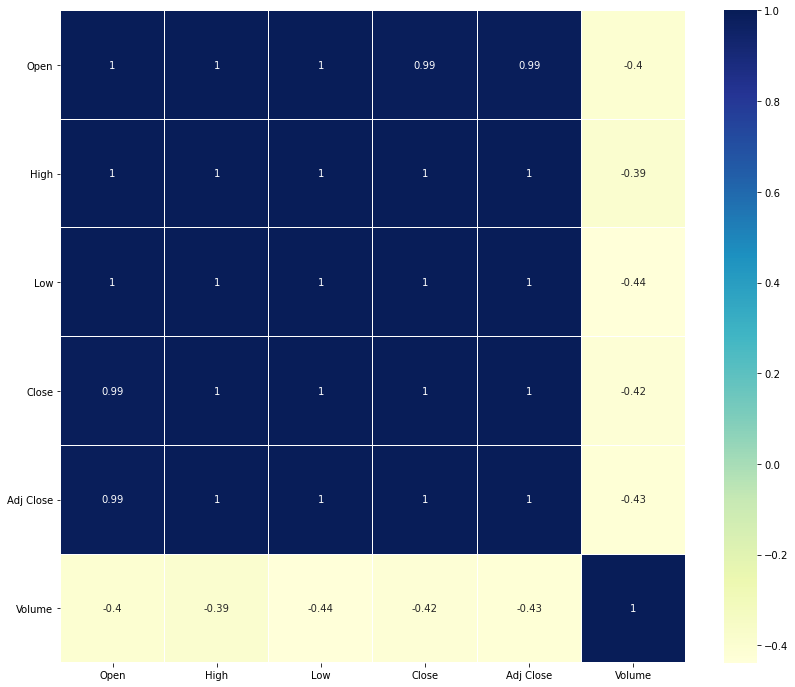

In [21]:
#create the correlation matrix heat map
plt.figure(figsize=(14,12))
sns.heatmap(dt_weekly.corr(),linewidths=.1,cmap="YlGnBu", annot=True)
plt.yticks(rotation=0);

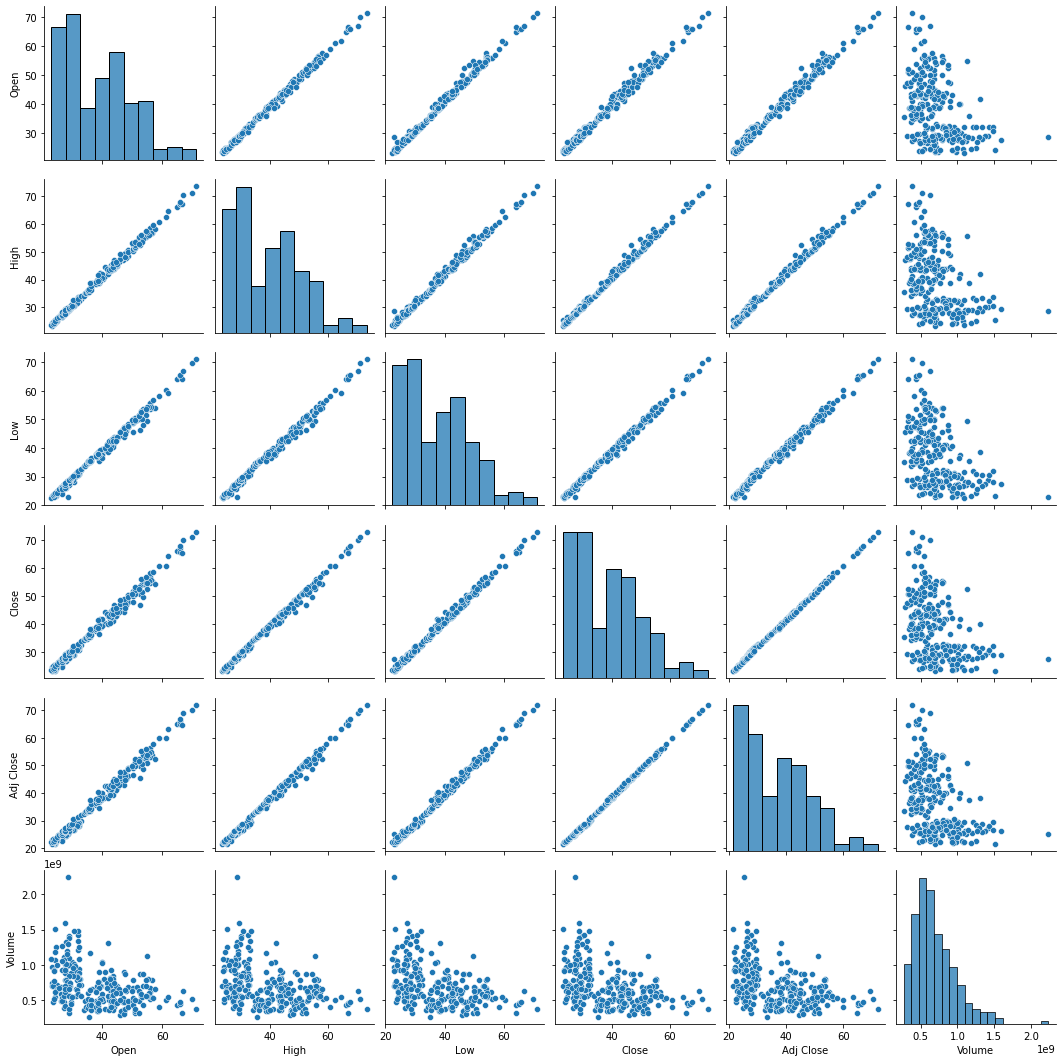

In [22]:
#create the pair plots
sns.pairplot(dt_weekly)

#  ***3. PreProcessing***

In [23]:
# drop all other columns and focusing on the Adj Close price
df = dt_weekly['Adj Close']
df

0      24.460564
1      24.925943
2      24.869184
3      26.176777
4      27.141579
         ...    
256    64.668098
257    66.899139
258    69.115349
259    70.234581
260    72.025833
Name: Adj Close, Length: 261, dtype: float64

In [24]:
# compute and print the autocorrelation for Adj Close
autocorrelation = df.autocorr()
print("The autocorrelation of weekly returns is %4.2f" %(autocorrelation))

The autocorrelation of weekly returns is 0.99


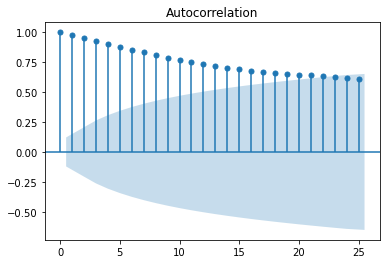

In [25]:
# plot of the autocorrelation on Adj Close
AdjClose_acf = plot_acf(df.values,lags=25,alpha=0.05)

In [26]:
# run augmented Dickey-Fuller test on Adj Close
results = adfuller(df)

In [27]:
# print p value
print(results[1])

0.9958835435458218


In [28]:
# print full results
print(results)

(1.185414202802349, 0.9958835435458218, 1, 259, {'1%': -3.4558530692911504, '5%': -2.872764881778665, '10%': -2.572751643088207}, 797.9402553549404)


*P value is 0.9958835435458218, much bigger than 0.05, meaning that we can't reject that the Adj Close price is random walk.
So, we could difference the series and see how the autocorrelation plot looks like.*

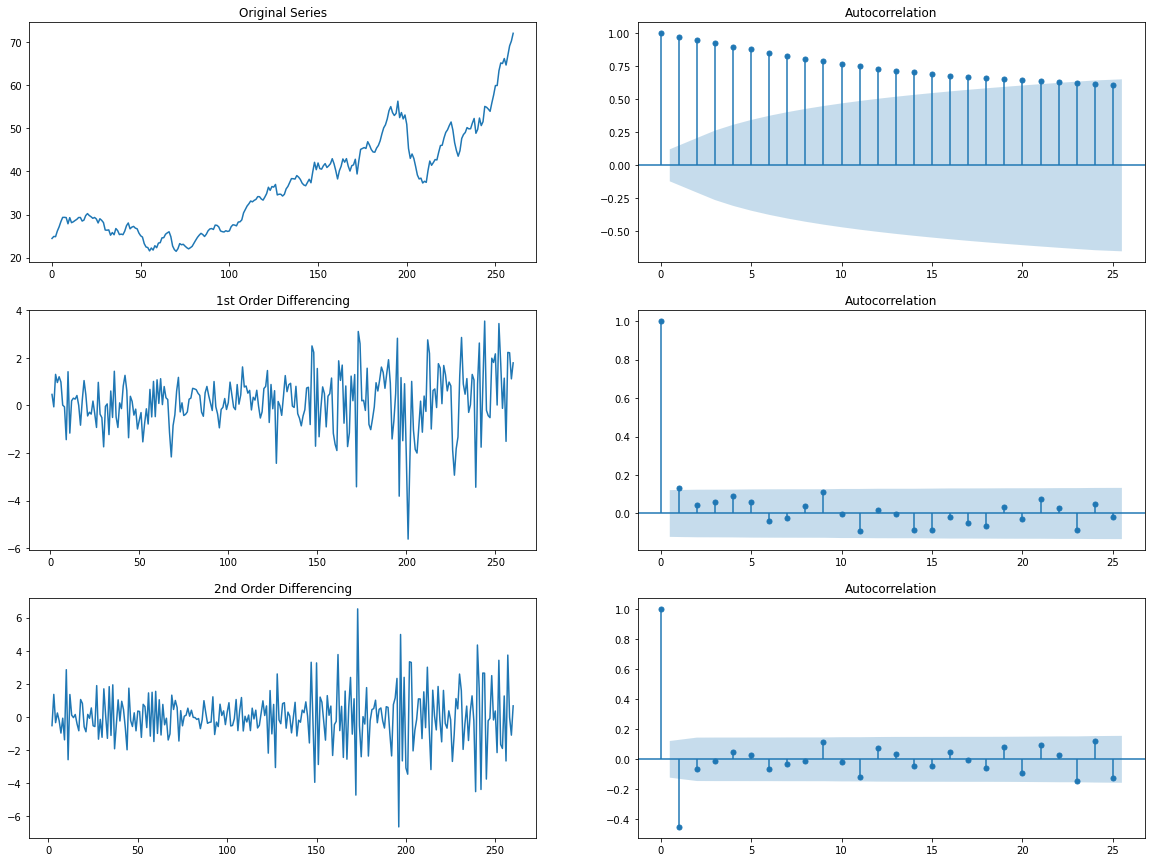

In [29]:
fig, axes = plt.subplots(3, 2,figsize=(20,15))
axes[0, 0].plot(df); axes[0, 0].set_title('Original Series')
plot_acf(df, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

*Looking at the autocorrelation plot for the 2nd differencing the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced. So, we will choose the order of differencing as 1 even though the series might not perfectly stationary (weak stationarity).*

In [30]:
# run augmented Dickey-Fuller test on diff(1) of Adj Close
results_diff1 = adfuller(df.diff().dropna())

In [31]:
# print p value
print(results_diff1[1])

4.315100826772732e-26


In [32]:
# print full results
print(results_diff1)

(-13.972780308649368, 4.315100826772732e-26, 0, 259, {'1%': -3.4558530692911504, '5%': -2.872764881778665, '10%': -2.572751643088207}, 794.6937239158107)


*P value is 4.315100826772732e-26, much smaller than 0.05, meaning that the first difference of Adj Close price is not random walk and reaches stationarity according to the plots above.*

<AxesSubplot:>

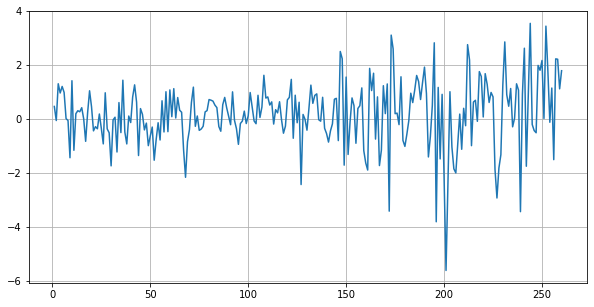

In [33]:
# plot the first difference of Adj Close price for 5 years
df.diff().dropna().plot(figsize =(10,5), grid=True)

<AxesSubplot:ylabel='Density'>

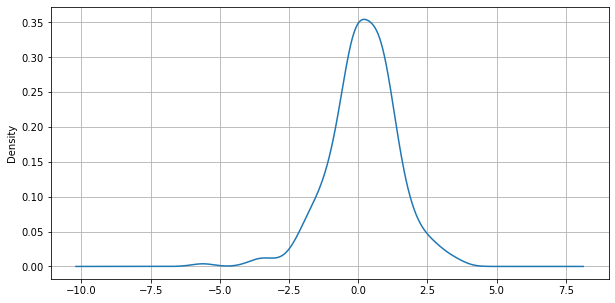

In [34]:
# Kernal Density plot for the first difference of Adj Close price
df.diff().dropna().plot(kind='kde',figsize =(10,5), grid=True)

# ***4. Modeling***

*We are using the commonly used Auto Regressive Integrated Moving Average (ARIMA) model to measure and predict the weekly adjusted closing prices of Apple stock in the 5-year period from the start of 2015 to the end of 2019.*

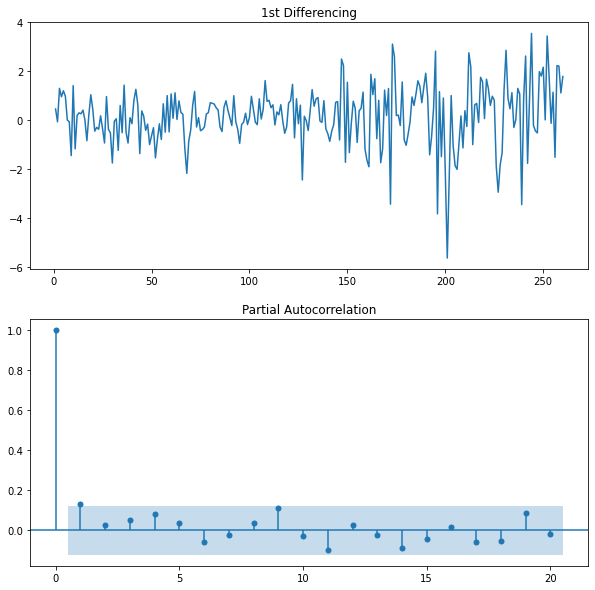

In [35]:
# PACF plot of 1st differenced series
fig, axes = plt.subplots(2, 1, figsize=(10,10))
axes[0].plot(df.diff().dropna()); axes[0].set_title('1st Differencing')
plot_pacf(df.diff().dropna(),lags=20, ax=axes[1])
plt.show()

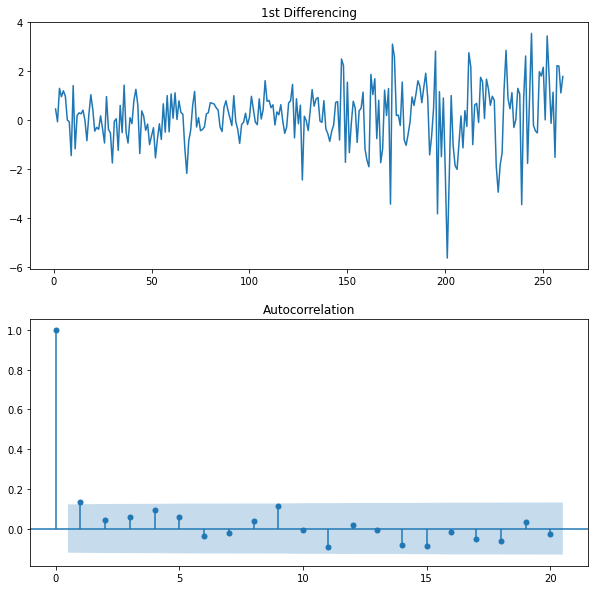

In [36]:
# ACF plot of 1st differenced series
fig, axes = plt.subplots(2, 1, figsize=(10,10))
axes[0].plot(df.diff().dropna()); axes[0].set_title('1st Differencing')
plot_acf(df.diff().dropna(),lags=20, ax=axes[1])
plt.show()

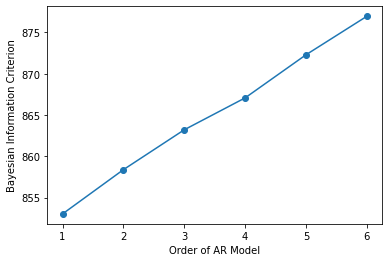

In [37]:
# plot the BIC as a function of p to choose the AR mode term
BIC = np.zeros(7)
for p in range(1,7):
    mod = ARIMA(df, order=(p,1,0))
    res = mod.fit()
# Save BIC for AR(p)    
    BIC[p] = res.bic
# Plot the BIC as a function of p
plt.plot(range(1,7), BIC[1:7], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Bayesian Information Criterion')
plt.show()

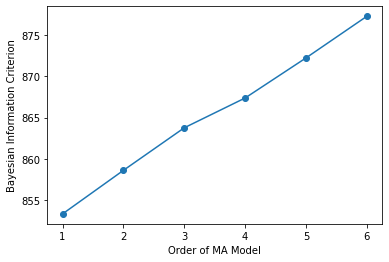

In [38]:
# plot the BIC as a function of q to choose the MA mode term
BIC = np.zeros(7)
for q in range(1,7):
    mod = ARIMA(df, order=(0,1,q))
    res = mod.fit()
# Save BIC for MA(q)    
    BIC[q] = res.bic
# Plot the BIC as a function of q
plt.plot(range(1,7), BIC[1:7], marker='o')
plt.xlabel('Order of MA Model')
plt.ylabel('Bayesian Information Criterion')
plt.show()

*Both ACF/PACF and BIC methods suggest a (1,1) for (p,q) value of ARIMA model with d=1.*

In [39]:
# run p=1, d=1, q=1 with ARIMA model
model = ARIMA(df.values, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  260
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -417.554
Method:                       css-mle   S.D. of innovations              1.206
Date:                Thu, 04 Nov 2021   AIC                            843.109
Time:                        22:46:22   BIC                            857.351
Sample:                             1   HQIC                           848.835
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1893      0.103      1.834      0.067      -0.013       0.392
ar.L1.D.y      0.7248      0.228      3.181      0.001       0.278       1.171
ma.L1.D.y     -0.6196      0.258     -2.401      0.0

*The P Values of the AR1 and MA1 terms are highly significant (<< 0.05), which is good.*

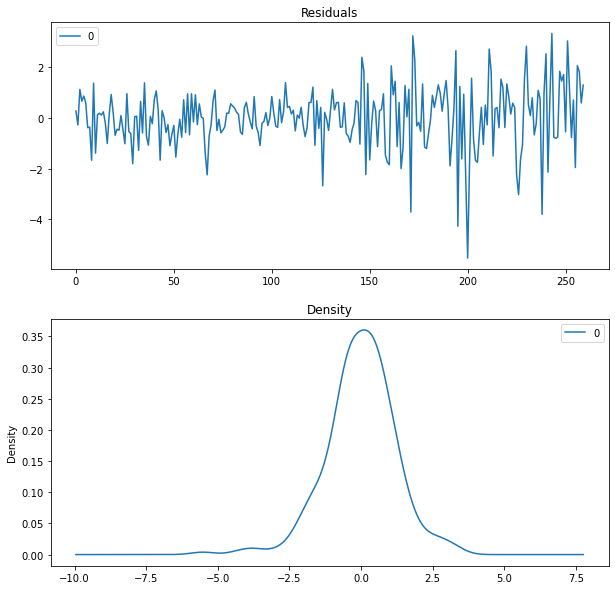

In [40]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(2,1, figsize=(10,10))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

**The residual errors seem fine with near zero mean; However, it rises concern about the heteroskedasticity since the variance is spreading a little bit over time. We need to check on it and fix it if it's true.**

In [41]:
# import and check the het_white test for heteroskedasticity of the residual errors.
import statsmodels.stats.api as sms
dfx = np.array(df[:-1]).reshape(260,1)
costant=np.ones(260).reshape(260,1)
dfexog=np.concatenate((costant,dfx),axis=1)
sms.diagnostic.het_white(model_fit.resid,dfexog)

(29.106136564092463,
 4.782805834296406e-07,
 16.198518630288685,
 2.3681924011055402e-07)

**Two p values are much less than 0.05 indicating that the residual errors is heteroskedastic biased. For instance, we will log the original data set to see if it would fix the heteroskedastic bias.**

In [42]:
# transform the data to log format
dflog = np.log(df)
dflog

0      3.197062
1      3.215909
2      3.213629
3      3.264873
4      3.301067
         ...   
256    4.169268
257    4.203186
258    4.235777
259    4.251841
260    4.277025
Name: Adj Close, Length: 261, dtype: float64

In [43]:
# run augmented Dickey-Fuller test on Adj Close
results = adfuller(dflog)

In [44]:
# print p value
print(results[1])

0.9731287552005335


In [45]:
# print full results
print(results)

(0.21570398150991585, 0.9731287552005335, 1, 259, {'1%': -3.4558530692911504, '5%': -2.872764881778665, '10%': -2.572751643088207}, -1008.4979631643716)


*P value is 0.9731287552115335, much bigger than 0.05, so we need to difference the logged data.

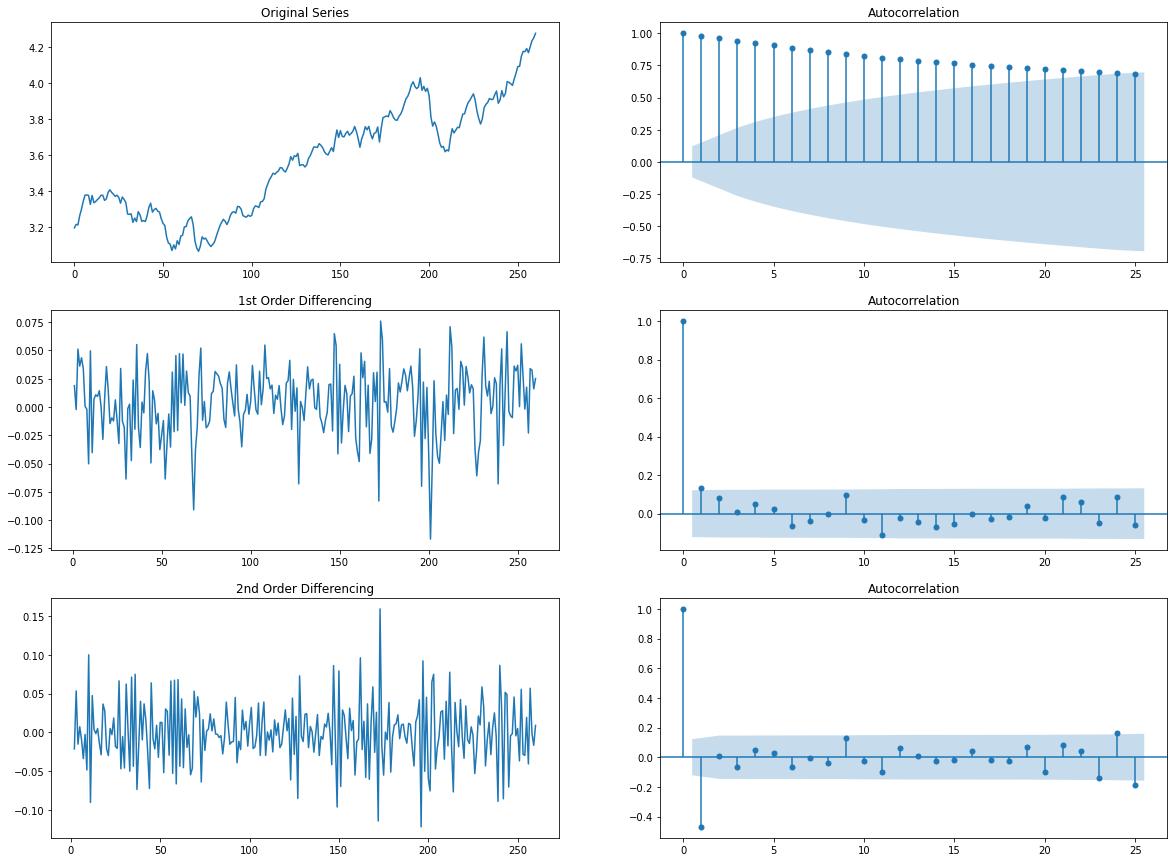

In [46]:
fig, axes = plt.subplots(3, 2,figsize=(20,15))
axes[0, 0].plot(dflog); axes[0, 0].set_title('Original Series')
plot_acf(dflog, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(dflog.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(dflog.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(dflog.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(dflog.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

*Same reason as above, so we will choose the first difference order for the model for now.*

In [47]:
# run augmented Dickey-Fuller test on diff(1) of logged data
results_diff1 = adfuller(dflog.diff().dropna())

In [48]:
# print p value
print(results_diff1[1])

3.89847030722504e-26


In [49]:
# print full results
print(results_diff1)

(-13.998619869979736, 3.89847030722504e-26, 0, 259, {'1%': -3.4558530692911504, '5%': -2.872764881778665, '10%': -2.572751643088207}, -1006.2616054576283)


*P value is 3.89847030722504e-26, much smaller than 0.05, meaning that the first difference of logged data is not random walk and reaches stationarity.*

<AxesSubplot:>

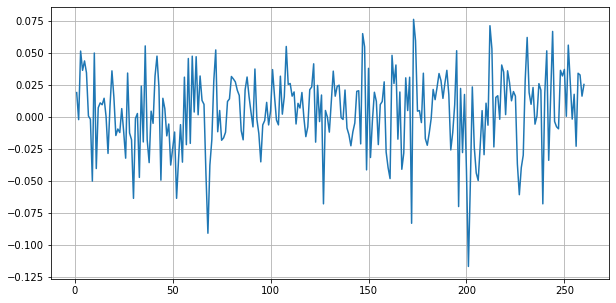

In [50]:
# plot the first difference of logged data for 5 years
dflog.diff().dropna().plot(figsize =(10,5), grid=True)

<AxesSubplot:ylabel='Density'>

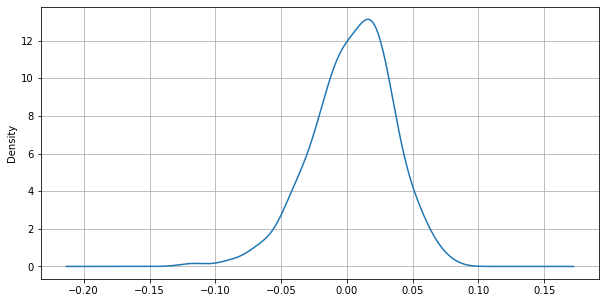

In [51]:
# Kernal Density plot for the first difference of logged data
dflog.diff().dropna().plot(kind='kde',figsize =(10,5), grid=True)

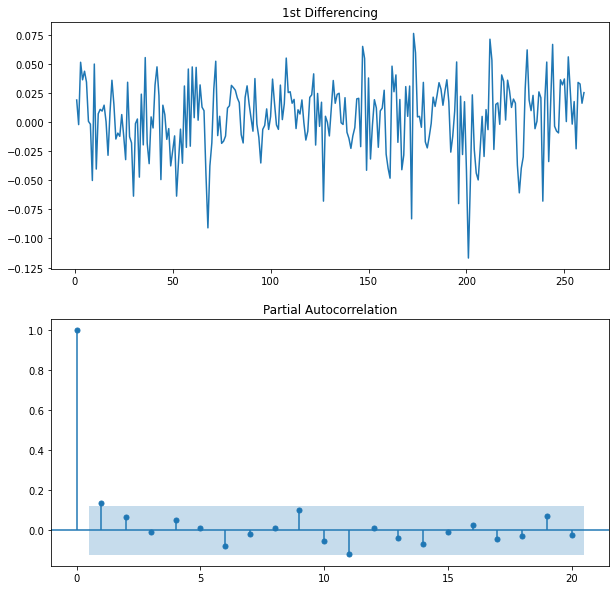

In [52]:
# PACF plot of 1st differenced series
fig, axes = plt.subplots(2, 1, figsize=(10,10))
axes[0].plot(dflog.diff().dropna()); axes[0].set_title('1st Differencing')
plot_pacf(dflog.diff().dropna(),lags=20, ax=axes[1])
plt.show()

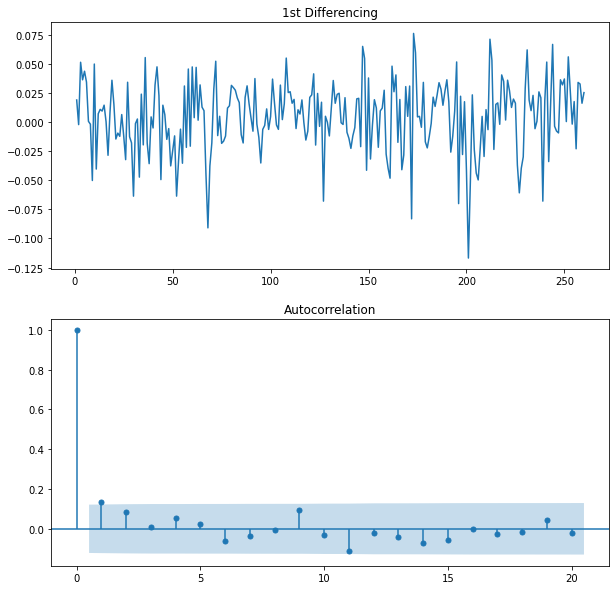

In [53]:
# ACF plot of 1st differenced series
fig, axes = plt.subplots(2, 1, figsize=(10,10))
axes[0].plot(dflog.diff().dropna()); axes[0].set_title('1st Differencing')
plot_acf(dflog.diff().dropna(),lags=20, ax=axes[1])
plt.show()

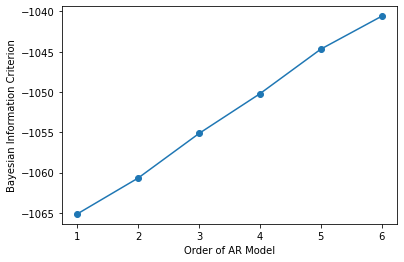

In [54]:
# plot the BIC as a function of p to choose the AR mode term
BIC = np.zeros(7)
for p in range(1,7):
    mod = ARIMA(dflog, order=(p,1,0))
    res = mod.fit()
# Save BIC for AR(p)    
    BIC[p] = res.bic
# Plot the BIC as a function of p
plt.plot(range(1,7), BIC[1:7], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Bayesian Information Criterion')
plt.show()

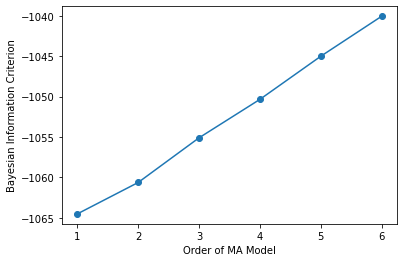

In [55]:
# plot the BIC as a function of q to choose the MA mode term
BIC = np.zeros(7)
for q in range(1,7):
    mod = ARIMA(dflog, order=(0,1,q))
    res = mod.fit()
# Save BIC for MA(q)    
    BIC[q] = res.bic
# Plot the BIC as a function of q
plt.plot(range(1,7), BIC[1:7], marker='o')
plt.xlabel('Order of MA Model')
plt.ylabel('Bayesian Information Criterion')
plt.show()

*Also, both ACF/PACF and BIC methods suggest the same (1,1) for (p,q) value of ARIMA model with d=1.*

In [56]:
# run p=1, d=1, q=1 with ARIMA model
model = ARIMA(dflog.values, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  260
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 541.408
Method:                       css-mle   S.D. of innovations              0.030
Date:                Thu, 04 Nov 2021   AIC                          -1074.817
Time:                        22:46:26   BIC                          -1060.574
Sample:                             1   HQIC                         -1069.091
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0042      0.002      1.783      0.075      -0.000       0.009
ar.L1.D.y      0.5162      0.306      1.687      0.092      -0.083       1.116
ma.L1.D.y     -0.3886      0.328     -1.184      0.2

*The P value of AR order(1) is 0.092, which is good; Nevertheless, the P value of MA order(1) is 0.236, which is not good. We will tune the values later.* 

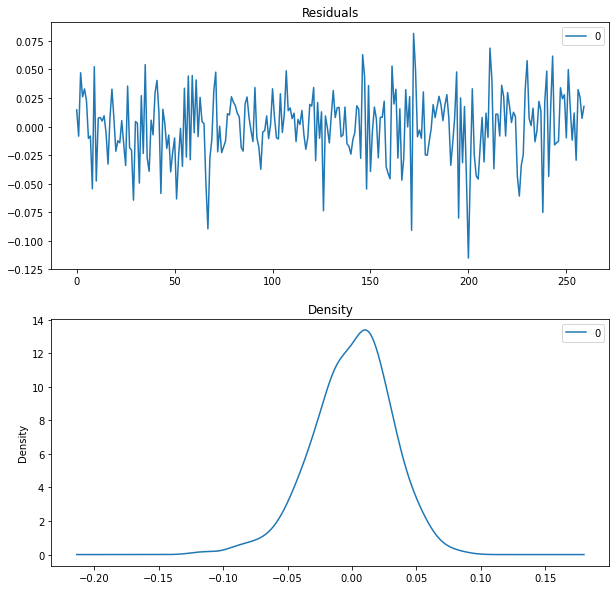

In [57]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(2,1, figsize=(10,10))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

**The residual errors seem fine with near zero mean and uniform variance, which is improved from the previous model with original data. We will confirm it with the het_white test in details.**

In [58]:
# check the het_white test for heteroskedasticity of the residual errors.
sms.diagnostic.het_white(model_fit.resid,dfexog)

(2.714896750629141, 0.2573165151709424, 1.3559441570844166, 0.2595411374163932)

**Two p values (0.2573 and 0.2595) are bigger than 0.05 indicating that the residual errors is NOT heteroskedastic. So, we could continue modeling.**

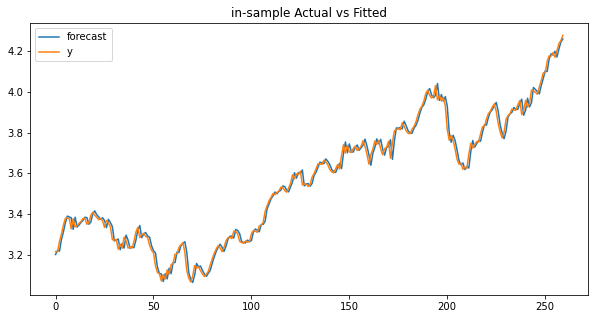

In [59]:
# Actual vs Fitted prediction
fig, ax = plt.subplots(figsize=(10,5))
model_fit.plot_predict(dynamic=False, ax=ax)
ax.set_title('in-sample Actual vs Fitted')
plt.show()

*The in-sample prediction seems good. Yet, we will try to optimize the model using the out-of-time cross validation.*

In [60]:
# split the data into train and test set in 9:1 with total 260 observations.
train = dflog[:235] 
test = dflog[235:]

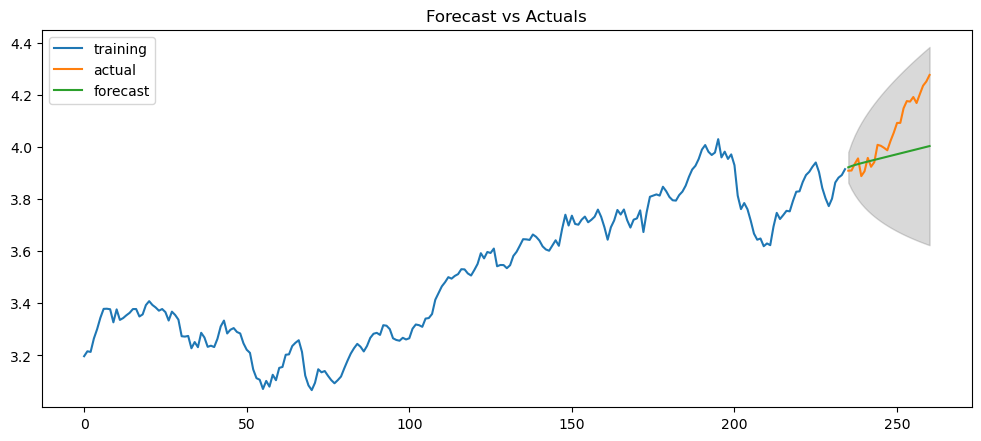

In [61]:
# Build Model
# model = ARIMA(train, order=(1,1,1))  
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(26, alpha=0.05)

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=10)
plt.show()

**From the chart, the ARIMA(1,1,1) model seems to give a directionally correct forecast. And the actual observed values lie within the 95% confidence band. That seems fine.** 


**But the predicted forecasts is below the actuals in most of the time. That means, by adding a small constant to our forecast, the accuracy will certainly improve. So, there is definitely scope for improvement.**

**So, we could try increasing the order of differencing to two, that is set d=2 and iteratively increase p to up to 5 and then q up to 5 to see which model gives least AIC/BIC and also look for a chart that gives closer actuals and forecasts.**

**While doing this, we will also keep an eye on the P values of the AR and MA terms in the model summary. They should be as close to zero, ideally, less than 0.05.**

                             ARIMA Model Results                              
Dep. Variable:            D.Adj Close   No. Observations:                  234
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 491.882
Method:                       css-mle   S.D. of innovations              0.030
Date:                Thu, 04 Nov 2021   AIC                           -971.764
Time:                        22:46:27   BIC                           -951.032
Sample:                             1   HQIC                          -963.405
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0031      0.002      1.406      0.160      -0.001       0.007
ar.L1.D.Adj Close    -0.2699      0.088     -3.057      0.002      -0.443      -0.097
ar.L2.D.Adj Close    -0.

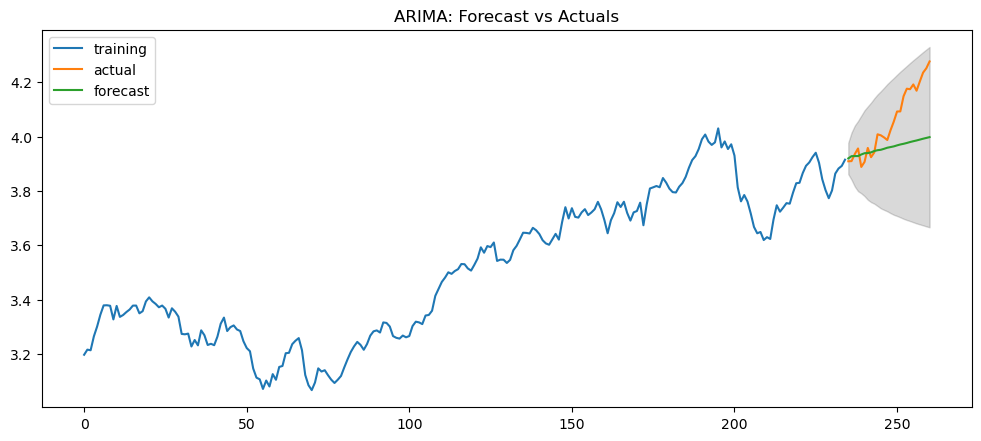

In [62]:
# Build Model with (2,1,2)
model = ARIMA(train, order=(2, 1, 2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(26, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('ARIMA: Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=10)
plt.show()

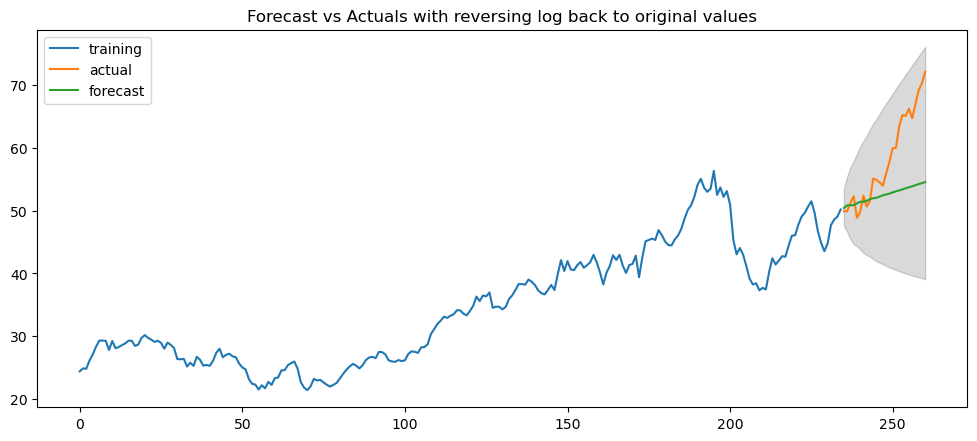

In [63]:
# Plot with reversing the log back to original values

plt.figure(figsize=(12,5), dpi=100)
plt.plot(np.exp(train), label='training')
plt.plot(np.exp(test), label='actual')
plt.plot(np.exp(fc_series), label='forecast')
plt.fill_between(np.exp(lower_series).index, np.exp(lower_series), np.exp(upper_series), 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals with reversing log back to original values')
plt.legend(loc='upper left', fontsize=10)
plt.show()

**After tring different combinations of (p,d,q) orders, the (2,1,2) orders result in best P values, almost all close to zero, and lowest BIC/AIC values. Although the actual and forcast are not significantly closer than before, overall the model is improved.**

*The commonly used accuracy metrics to judge forecasts are:*

1. Mean Absolute Percentage Error (MAPE)
2. Mean Absolute Error (MAE)
3. Mean Percentage Error (MPE)
4. Root Mean Squared Error (RMSE)
5. Correlation between the Actual and the Forecast (corr)
6. Min-Max Error (minmax)

*We will check all of them, focusing on the MAPE, MPE, and CORR.*


In [78]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(actual - forecast)/np.abs(actual))  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':"{:.2%}".format(mape), 'mae': "{:.4}".format(mae), 
            'mpe': "{:.2%}".format(mpe), 'rmse':"{:.4}".format(rmse),
            'corr':"{:.4}".format(corr), 'minmax':"{:.2%}".format(minmax)})

forecast_accuracy(fc, test.values)

{'mape': '2.52%',
 'mae': '0.1046',
 'mpe': '-2.26%',
 'rmse': '0.1374',
 'corr': '0.963',
 'minmax': '2.52%'}

**Around 2.52% MAPE and -2.26% MPE implies the model is highly accurate and under biased in predicting the next 26 observations. Also, score of 0.963 for CORR implies the predicted values are highly correlated to the actual values which is a good sign.**

## Other Models ##

#### 1. TBATS

*TBATS* is also a forecasting method to model time series data. The main aim of this is to forecast time series with complex seasonal patterns using exponential smoothing.

TBATS is an acronym for key features of the model:

* T: Trigonometric seasonality
* B: Box-Cox transformation
* A: ARIMA errors
* T: Trend
* S: Seasonal components

In [79]:
from tbats import TBATS, BATS

In [80]:
# Fit the model
estimator = TBATS(seasonal_periods=(4,52),use_trend=True)
model = estimator.fit(train)
# Forecast
y_forecast = model.forecast(steps=26)

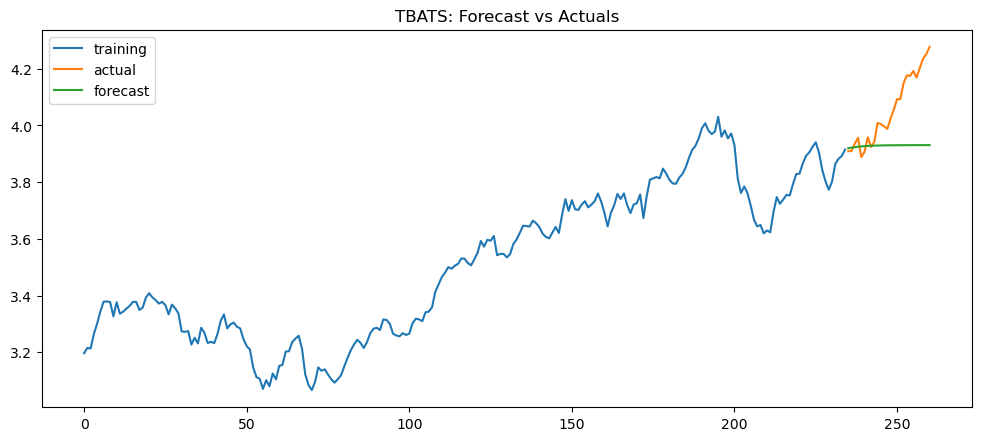

In [81]:
#Make as pandas series
fc_series = pd.Series(y_forecast, index=test.index)

#Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('TBATS: Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=10)
plt.show()

In [82]:
forecast_accuracy(y_forecast, test.values)

{'mape': '3.19%',
 'mae': '0.1326',
 'mpe': '-3.03%',
 'rmse': '0.1737',
 'corr': '0.6981',
 'minmax': '3.19%'}

**Around 3.19% MAPE and -3.03% MPE implies the model is also highly accurate and under biased in predicting the next 26 observations. Nevertheless, score of 0.6981 for CORR implies the predicted values are less correlated to the actual values (compare to the 0.963 from ARIMA model)which is not good enough.**

#### 2. HWES (Holt-Winters Exponential Smoothing)

*Holt-Winters Exponential Smoothing* - also known as triple exponential smoothing - is used for forecasting time series data that exhibits both a trend and a seasonal variation.

In [83]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

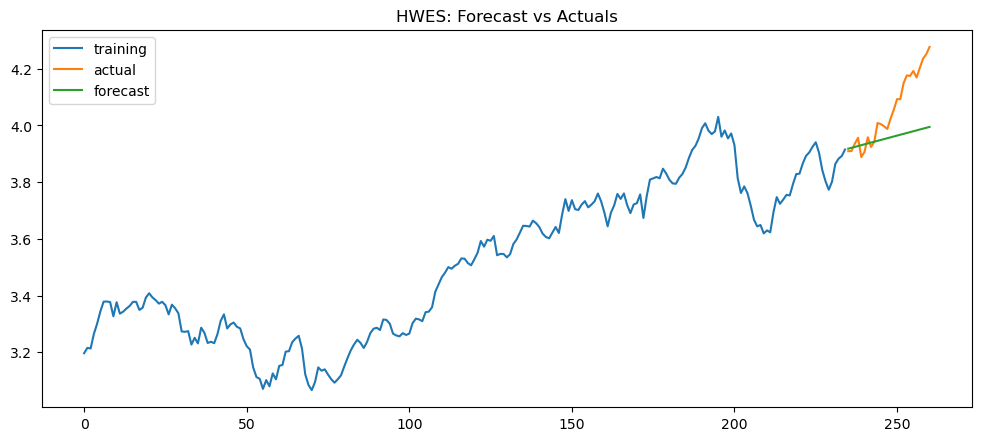

In [84]:
#fit model
model = ExponentialSmoothing(train, trend='add')
model_fit = model.fit()
#make prediction
y_forecast = model_fit.forecast(26)

fc_series = pd.Series(y_forecast, index=test.index)

#Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('HWES: Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=10)
plt.show()

In [85]:
forecast_accuracy(y_forecast, test.values)

{'mape': '2.56%',
 'mae': '0.1063',
 'mpe': '-2.35%',
 'rmse': '0.1397',
 'corr': '0.9662',
 'minmax': '2.56%'}

**Around 2.56% MAPE and -2.35% MPE implies the model is also highly accurate and under biased in predicting the next 26 observations. Also, score of 0.9662 for CORR implies the predicted values are highly correlated to the actual values which is pretty good.**

### Summary

**Based on the results of the metrics used, ARIMA and HWES performed better than TBATS does. For instance, we will choose ARIMA for overall better performance over HWES.**
